# Import required libraries

In [178]:
import pandas as pd
from datetime import datetime
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

#### Load and read the data

In [140]:
food = pd.read_csv('food_orders_new_delhi.csv')
food.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


#### Clean the dataset for inconsistencies, missing values, or irrelevant information.


<Axes: >

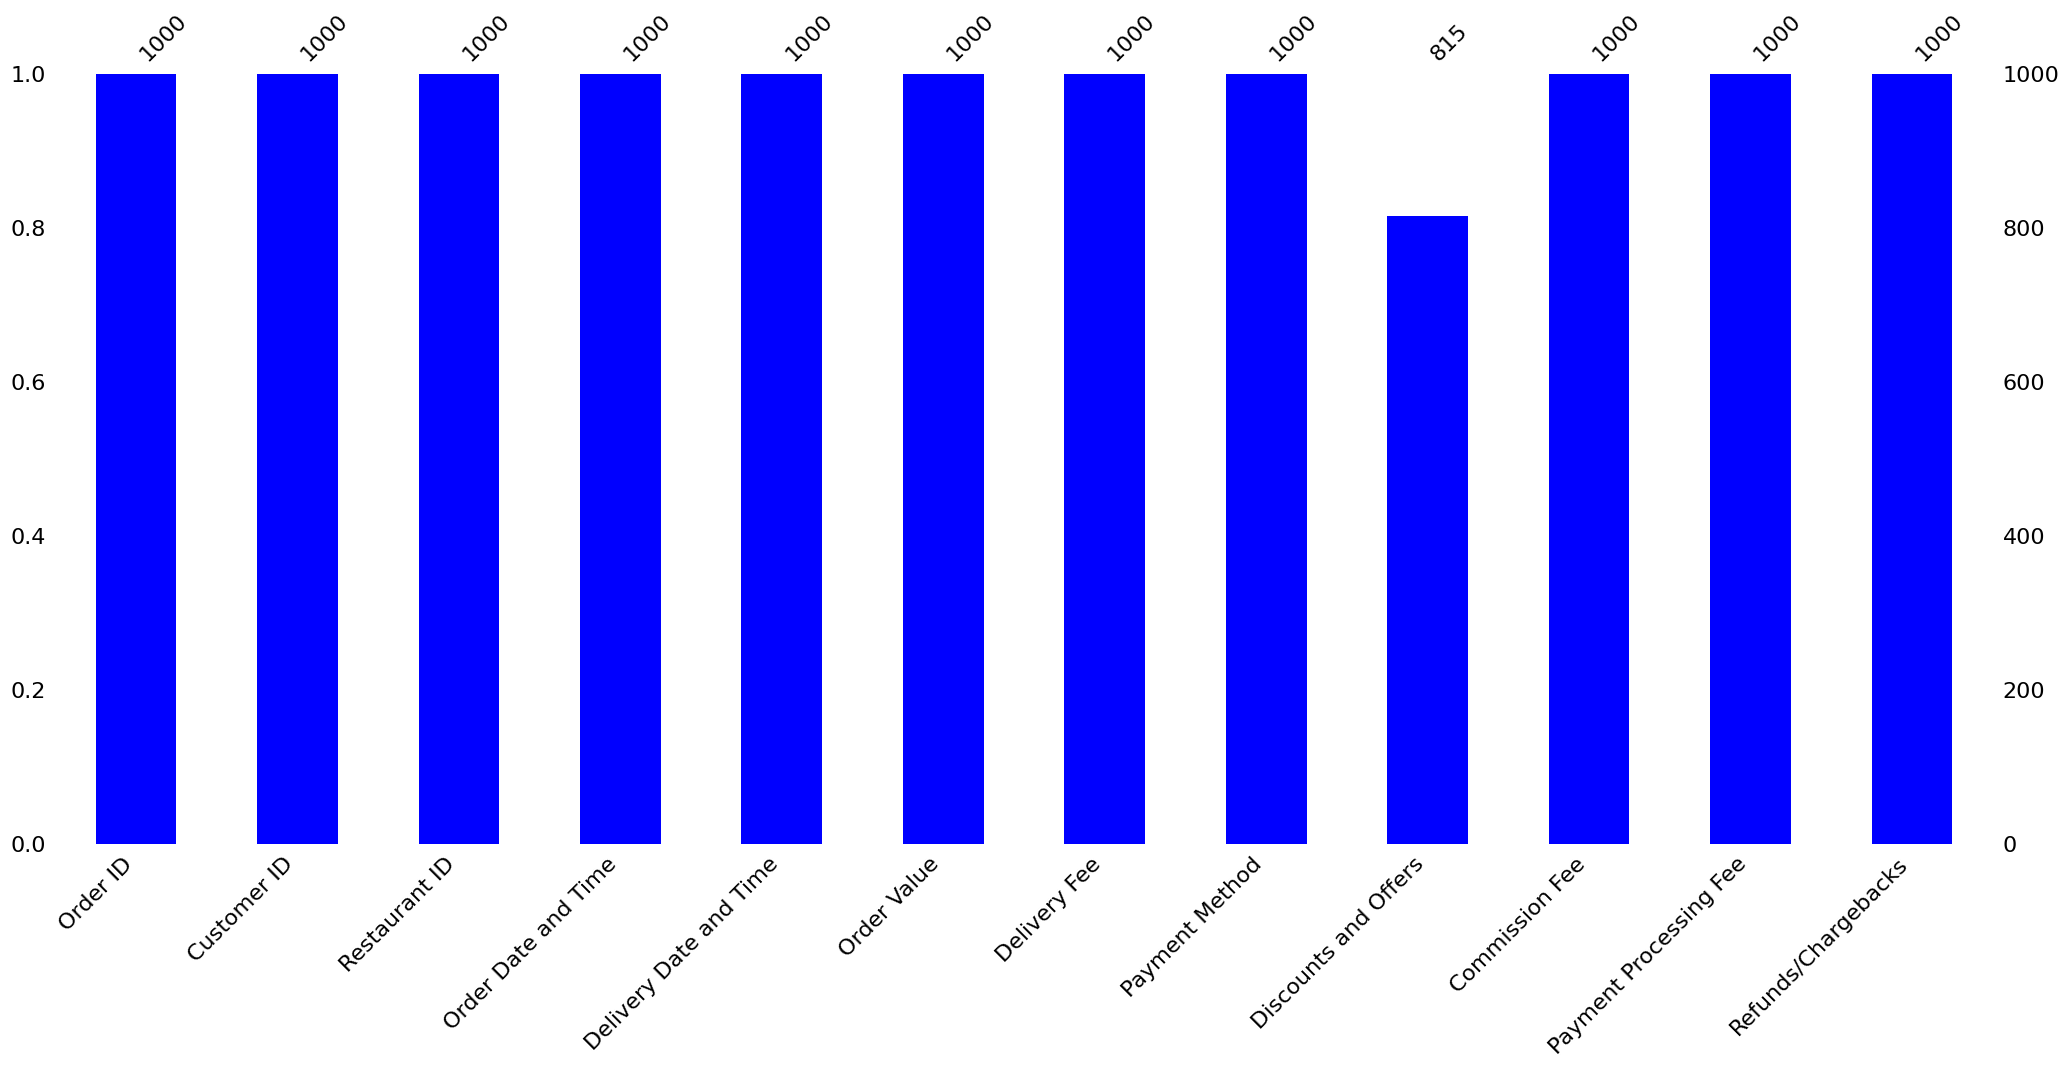

In [141]:
# Check if there are missing values on the dataset

msno.bar(food, color='blue')

In [142]:
# Look into 'Discounts and Offers' column to see what happened

print(food['Discounts and Offers'].unique())

['5% on App' '10%' '15% New User' nan '50 off Promo']


In [143]:
# Since orders without discounts make nan values, we can fill the missing values in 'Discounts and Offers' column with 'None'

food['Discounts and Offers'].fillna('None', inplace=True)

print(food['Discounts and Offers'].unique())
print(  )
print(food.isnull().sum())

['5% on App' '10%' '15% New User' 'None' '50 off Promo']

Order ID                  0
Customer ID               0
Restaurant ID             0
Order Date and Time       0
Delivery Date and Time    0
Order Value               0
Delivery Fee              0
Payment Method            0
Discounts and Offers      0
Commission Fee            0
Payment Processing Fee    0
Refunds/Chargebacks       0
dtype: int64


In [144]:
# Check datatypes of the dataset

print(food.dtypes)

Order ID                   int64
Customer ID               object
Restaurant ID             object
Order Date and Time       object
Delivery Date and Time    object
Order Value                int64
Delivery Fee               int64
Payment Method            object
Discounts and Offers      object
Commission Fee             int64
Payment Processing Fee     int64
Refunds/Chargebacks        int64
dtype: object


In [145]:
# Convert dtypes of the two date and time columns to datetime in order to analyze

food['Order Date and Time'] = pd.to_datetime(food['Order Date and Time'])
food['Delivery Date and Time'] = pd.to_datetime(food['Delivery Date and Time'])
food[['Order Date and Time', 'Delivery Date and Time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order Date and Time     1000 non-null   datetime64[ns]
 1   Delivery Date and Time  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 15.8 KB


### Brief Summary
* Missing data in 'Discounts and Offers' column have been filled with 'none' which means there's no discount for the order.

* 'Order Date and Time' and 'Delivery Date and Time' columns have been converted to datetime format.

# 1. Detailed Cost Analysis

#### Identifying the major cost components associated with delivering food orders, including direct costs like delivery fees and indirect costs like discounts and payment processing fees.

In [146]:
# There are 5 kinds of Discount - '5% on App', '10%', '15% New User', '50 off Promo' and 'none'.
# So, we can create a function to extract numeric values from the 'Discounts and Offers' string in order to calculate the cost easily.

def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

In [147]:
# Apply the function to create a new 'Discount Value' column

food['Discount Percentage'] = food['Discounts and Offers'].apply(lambda x: extract_discount(x))

In [148]:

# Calculate the discount amount based on the order value for percentage discounts

food['Discount Amount'] = food.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)


In [149]:
# Adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column

food['Discount Amount'] = food.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)
print(food[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head())
print()
print(food.info())

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                 None                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             

In [150]:
# Calculate direct, indirect and total costs 

food['Direct Cost'] = food['Delivery Fee']
food['Indirect Cost'] = food['Payment Processing Fee'] + food['Discount Amount']
food['Total Cost'] = food['Direct Cost'] + food['Indirect Cost']
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             1000 non-null   int64         
 6   Delivery Fee            1000 non-null   int64         
 7   Payment Method          1000 non-null   object        
 8   Discounts and Offers    1000 non-null   object        
 9   Commission Fee          1000 non-null   int64         
 10  Payment Processing Fee  1000 non-null   int64         
 11  Refunds/Chargebacks     1000 non-null   int64         
 12  Discount Percentage     1000 non-null   float64  

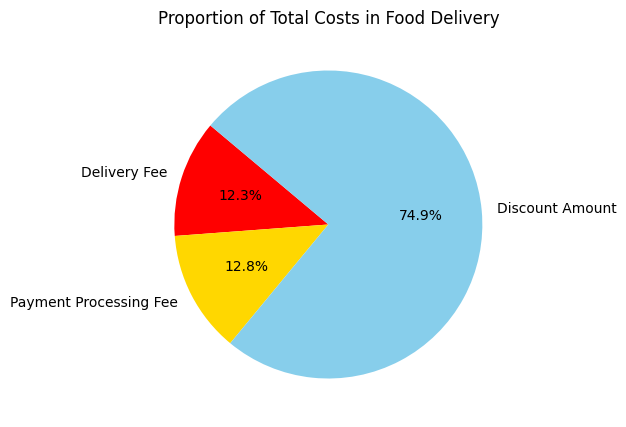

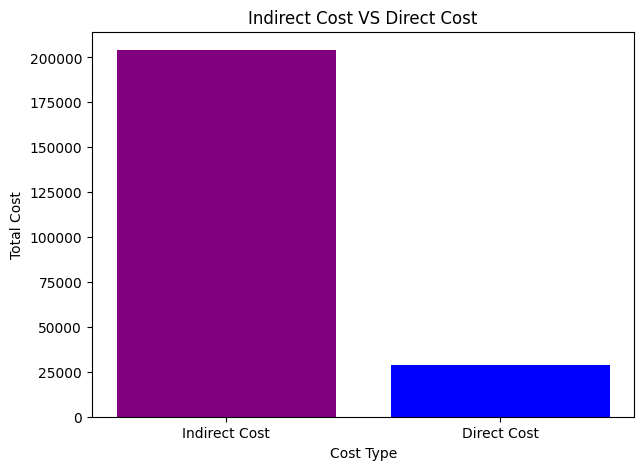

In [151]:
# Look into the proportion of the cost

# Figure 1 - Proportion of Total Costs
costs_detail = food[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 5))
plt.pie(costs_detail, labels=costs_detail.index, autopct='%1.1f%%', startangle=140, colors=['red', 'gold', 'skyblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

# Figure 2 - Comparing indirect and direct cost
plt.figure(figsize=(7, 5)) 
plt.bar(x=['Indirect Cost', 'Direct Cost'], height=[food['Indirect Cost'].sum(), food['Direct Cost'].sum()], color=['purple', 'blue'])
plt.title('Indirect Cost VS Direct Cost')
plt.xlabel('Cost Type')
plt.ylabel('Total Cost')
plt.show()


### Brief Summary

* A new column, Discount Amount, has been calculated based on the Discounts and Offers column. This was achieved by extracting percentage discounts or fixed amounts and applying them to the order value.

* Figure 1 illustrates 'Discounts' constitute a significant portion of the costs. Likewise, Figure 2 shows that Indirect cost significantly higher than Direct cost. So we can assume that promotional strategies might be heavily impacting overall profitability.

# 2. Profitability Evaluation

#### Calculating the profitability of individual orders and aggregating this data to assess overall profitability. This involves examining how revenue generated from commission fees measures against the total costs.

In [152]:
# Calculate total costs and revenue per order

food['Total Cost'] = food['Delivery Fee'] + food['Payment Processing Fee'] + food['Discount Amount']
food['Revenue'] = food['Commission Fee']
food['Profit'] = food['Revenue'] - food['Total Cost']

food[['Total Cost', 'Revenue', 'Profit']].head()

,Total Cost,Revenue,Profit
0,142.70,150,7.30
1,161.60,198,36.40
2,215.55,195,-20.55
3,77.00,146,69.00
4,1076.00,130,-946.00


In [153]:
# Aggregate data to get overall metrics

total_orders = food.shape[0]
total_revenue = food['Revenue'].sum()
total_cost = food['Total Cost'].sum()
total_profit = food['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Cost": total_cost,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Cost': 232709.85, 'Total Profit': -105719.85}


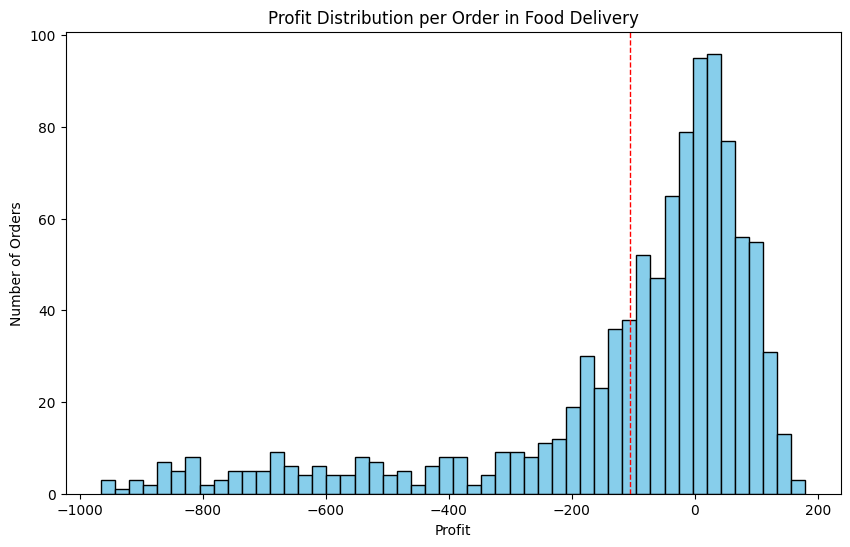

In [154]:
# Visualize the profitability of individual orders

plt.figure(figsize=(10, 6))
plt.hist(food['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

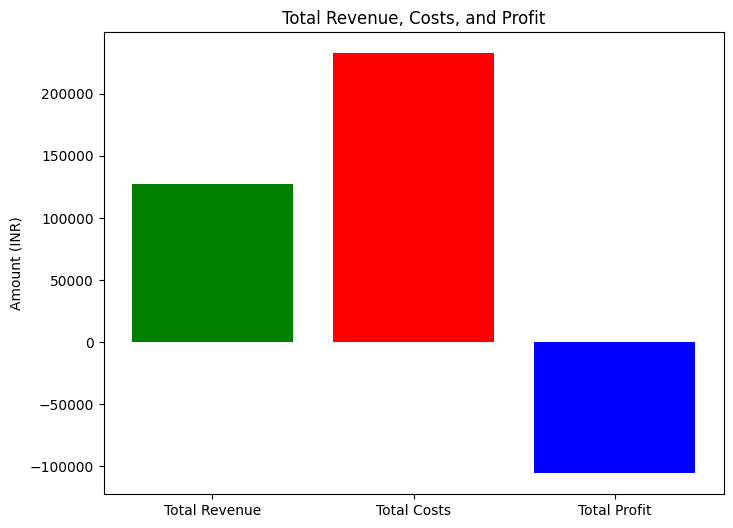

In [155]:
# A bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_cost, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

# 3. Strategic Recommendations for Improvement

#### Based on the cost and profitability analysis, identifying actionable strategies to reduce costs, adjust pricing, commission fees, and discount strategies to improve profitability. This includes finding a “sweet spot” for commission and discount percentages that ensures profitability across orders.

In [156]:
# Filter the dataset for profitable orders
profitable_orders = food[food['Profit'] > 0]
profitable_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, 0 to 997
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                415 non-null    int64         
 1   Customer ID             415 non-null    object        
 2   Restaurant ID           415 non-null    object        
 3   Order Date and Time     415 non-null    datetime64[ns]
 4   Delivery Date and Time  415 non-null    datetime64[ns]
 5   Order Value             415 non-null    int64         
 6   Delivery Fee            415 non-null    int64         
 7   Payment Method          415 non-null    object        
 8   Discounts and Offers    415 non-null    object        
 9   Commission Fee          415 non-null    int64         
 10  Payment Processing Fee  415 non-null    int64         
 11  Refunds/Chargebacks     415 non-null    int64         
 12  Discount Percentage     415 non-null    float64       


In [157]:
# Separate the dataset into 4 quartiles based on quantile standards.
profitable_quantiles = profitable_orders['Profit'].quantile([0.25, 0.5, 0.75])

# Assign the category based on the quantiles
def assign_category(profit):
    if profit <= profitable_quantiles[0.25]:
        return 'low'
    elif profit <= profitable_quantiles[0.5]:
        return 'medium'
    elif profit <= profitable_quantiles[0.75]:
        return 'high'
    else:
        return 'very high'

# Make 4 new columns - low, medium, high and very high
profitable_orders['Profit_category'] = profitable_orders['Profit'].apply(assign_category)
profitable_orders.head()


/var/folders/ll/22q89fv95hbb3yt5tf_x_5lc0000gp/T/ipykernel_29217/2147452973.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_orders['Profit_category'] = profitable_orders['Profit'].apply(assign_category)


,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks,Discount Percentage,Discount Amount,Direct Cost,Indirect Cost,Total Cost,Revenue,Profit,Profit_category
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,5.0,95.70,0,142.70,142.70,150,7.30,low
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,10.0,98.60,40,121.60,161.60,198,36.40,medium
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,27,0,0.0,0.00,50,27.00,77.00,146,69.00,high
5,6,C7265,R2777,2024-01-25 04:36:52,2024-01-25 05:27:52,439,20,Cash on Delivery,10%,92,27,150,10.0,43.90,20,70.90,90.90,92,1.10,low
6,7,C1466,R2457,2024-01-12 23:55:48,2024-01-13 00:48:48,303,30,Digital Wallet,5% on App,144,12,50,5.0,15.15,30,27.15,57.15,144,86.85,high


In [175]:
# Calculate the averae percentages of each profitable categories and visualize them

def calculate_avg_percentage(profitable_orders, category):
    total_commission = profitable_orders.loc[profitable_orders['Profit_category'] == category, 'Commission Fee'].sum()
    total_order_value = profitable_orders.loc[profitable_orders['Profit_category'] == category, 'Order Value'].sum()

    avg_percentage = (total_commission / total_order_value) * 100
    return avg_percentage

categories = ['low', 'medium', 'high', 'very high']

for category in categories:
    avg_com_percentage = calculate_avg_percentage(profitable_orders, category)
    print(f"The average commission percentage for {category}-profit orders is: {avg_com_percentage:.2f}%")



The average commission percentage for low-profit orders is: 13.70%
The average commission percentage for medium-profit orders is: 14.34%
The average commission percentage for high-profit orders is: 19.71%
The average commission percentage for very high-profit orders is: 22.12%


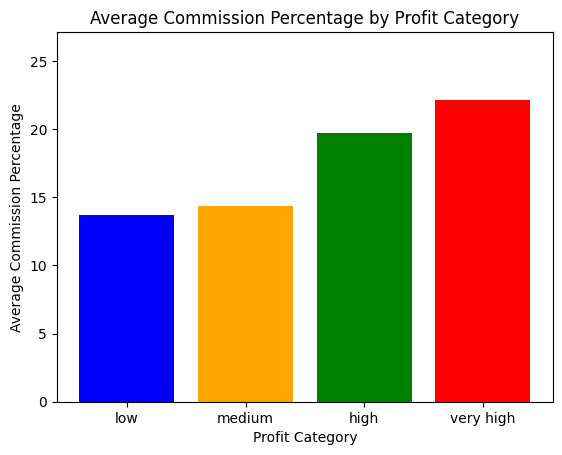

In [163]:
categories = ['low', 'medium', 'high', 'very high']
avg_percentages = []

for category in categories:
    avg_percentage = calculate_avg_percentage(profitable_orders, category)
    avg_percentages.append(avg_percentage)

plt.bar(categories, avg_percentages, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Profit Category')
plt.ylabel('Average Commission Percentage')
plt.title('Average Commission Percentage by Profit Category')
plt.ylim(0, max(avg_percentages) + 5) 
plt.show()


In [176]:
# Likewise, let's calculate the average discount percentages of each categories and visualize them.

def calculate_discount_percentage(profitable_orders, category):
    total_discount = profitable_orders.loc[profitable_orders['Profit_category'] == category, 'Discount Amount'].sum()
    total_order_value = profitable_orders.loc[profitable_orders['Profit_category'] == category, 'Order Value'].sum()

    avg_dis_percentage = (total_discount / total_order_value) * 100
    return avg_dis_percentage

categories = ['low', 'medium', 'high', 'very high']

for category in categories:
    avg_dis_percentage = calculate_discount_percentage(profitable_orders, category)
    print(f"The average discount percentage for {category}-profit orders is: {avg_dis_percentage:.1f}%")


The average discount percentage for low-profit orders is: 5.8%
The average discount percentage for medium-profit orders is: 4.1%
The average discount percentage for high-profit orders is: 3.7%
The average discount percentage for very high-profit orders is: 1.4%


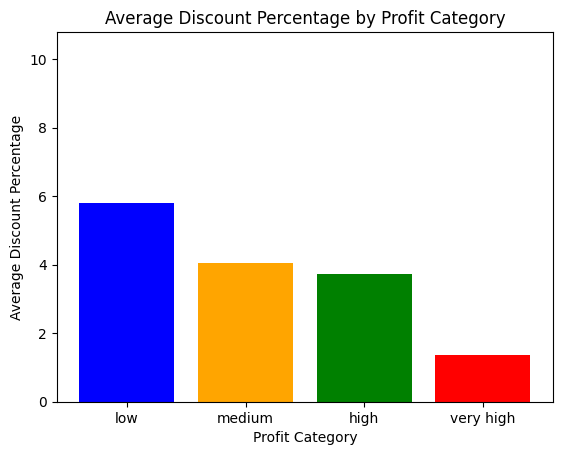

In [172]:
categories = ['low', 'medium', 'high', 'very high']
avg_dist_percentages = []

for category in categories:
    avg_dist_percentage = calculate_discount_percentage(profitable_orders, category)
    avg_dist_percentages.append(avg_dist_percentage)

plt.bar(categories, avg_dist_percentages, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Profit Category')
plt.ylabel('Average Discount Percentage')
plt.title('Average Discount Percentage by Profit Category')
plt.ylim(0, max(avg_dist_percentages) + 5) 
plt.show()

### Brief Summary

* The profit of food delivery orders is clearly proportional to the commission, increasing as the commission rises, and inversely proportional to the discount, decreasing as the discount decreases.

* Now we can simulate what the profit would be if we apply the average commission/discount ratio for each profit level to the entire dataset.

# 4. Impact Simulation of Proposed Strategies

#### Simulating the financial impact of the recommended strategies on profitability, using the dataset to forecast how adjustments in commission rates and discount strategies could potentially transform current losses into profits.

In [177]:
# First, I will simulate the recommended commission/discount percentage based on low-profit.

# simulate profitability with recommended discounts and commissions of low profit
recommended_commission_percentage_low = 13.7 # 13.7%
recommended_discount_percentage_low = 5.8 # 5.8%


# calculate the simulated commission fee and discount amount using recommended percentages
food['Simulated Commission Fee low'] = food['Order Value'] * (recommended_commission_percentage_low / 100)
food['Simulated Discount Amount low'] = food['Order Value'] * (recommended_discount_percentage_low / 100)

# recalculate total costs and profit with simulated values
food['Simulated Total Costs low'] = (food['Delivery Fee'] +
                                        food['Payment Processing Fee'] +
                                        food['Simulated Discount Amount low'])

food['Simulated Profit low'] = (food['Simulated Commission Fee low'] -
                                   food['Simulated Total Costs low'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

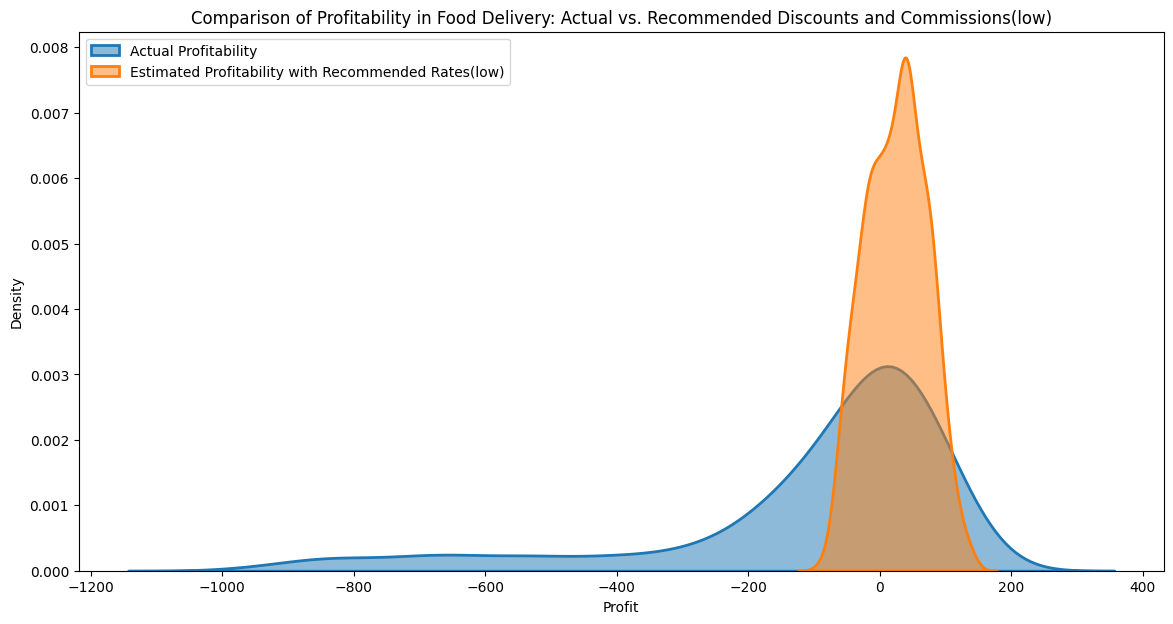

In [179]:
# visualizing the comparison

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food['Simulated Profit low'], label='Estimated Profitability with Recommended Rates(low)', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions(low)')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

In [180]:
# Do the same thing with other categories and compare them with visualizing

recommended_commission_percentage_mid = 14.34 
recommended_discount_percentage_mid = 4.1
recommended_commission_percentage_high = 19.71 
recommended_discount_percentage_high = 3.7 
recommended_commission_percentage_veryhigh = 22.12 
recommended_discount_percentage_veryhigh = 1.4 

# medium category

food['Simulated Commission Fee mid'] = food['Order Value'] * (recommended_commission_percentage_mid / 100)
food['Simulated Discount Amount mid'] = food['Order Value'] * (recommended_discount_percentage_mid / 100)

food['Simulated Total Costs mid'] = (food['Delivery Fee'] +
                                        food['Payment Processing Fee'] +
                                        food['Simulated Discount Amount mid'])

food['Simulated Profit mid'] = (food['Simulated Commission Fee mid'] -
                                   food['Simulated Total Costs mid'])

# high category

food['Simulated Commission Fee high'] = food['Order Value'] * (recommended_commission_percentage_high / 100)
food['Simulated Discount Amount high'] = food['Order Value'] * (recommended_discount_percentage_high / 100)

food['Simulated Total Costs high'] = (food['Delivery Fee'] +
                                        food['Payment Processing Fee'] +
                                        food['Simulated Discount Amount high'])

food['Simulated Profit high'] = (food['Simulated Commission Fee high'] -
                                   food['Simulated Total Costs high'])

# very high category

food['Simulated Commission Fee veryhigh'] = food['Order Value'] * (recommended_commission_percentage_veryhigh / 100)
food['Simulated Discount Amount veryhigh'] = food['Order Value'] * (recommended_discount_percentage_veryhigh / 100)

food['Simulated Total Costs veryhigh'] = (food['Delivery Fee'] +
                                        food['Payment Processing Fee'] +
                                        food['Simulated Discount Amount veryhigh'])

food['Simulated Profit veryhigh'] = (food['Simulated Commission Fee veryhigh'] -
                                   food['Simulated Total Costs veryhigh'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

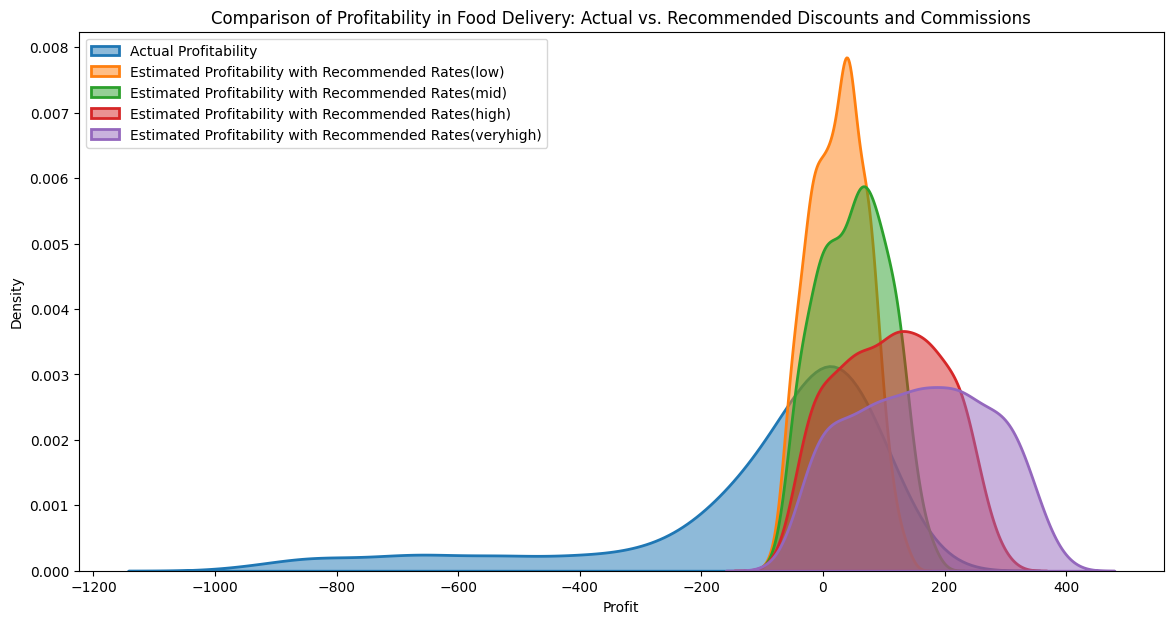

In [185]:
plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food['Simulated Profit low'], label='Estimated Profitability with Recommended Rates(low)', fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(food['Simulated Profit mid'], label='Estimated Profitability with Recommended Rates(mid)', fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(food['Simulated Profit high'], label='Estimated Profitability with Recommended Rates(high)', fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(food['Simulated Profit veryhigh'], label='Estimated Profitability with Recommended Rates(veryhigh)', fill=True, alpha=0.5, linewidth=2)


plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### Brief Summary 
* The distributions are more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.

# 5. Conclusion

#### After analyzing the existing dataset, it became apparent that the total costs incurred by the business exceed its revenue, resulting in overall losses. Through this analysis, it was identified that adjusting the discount amounts downwards and increasing the commission fees could potentially enhance profitability.

#### However, it is evident that if the delivery service owner decides to drastically decrease the discount amounts or significantly raise the commission fees, it may deter customers from using the service altogether. Consequently, I segmented the options into four categories based on profitability quantiles. Essentially, this allows owners to make informed decisions on how to operate their business by choosing which simulated commission fee or discount amounts would be applied while ensuring profitability is maintained. 

#### In other words, I believe this approach empowers owners to select commission fee and discount levels that balance profitability with customer retention, ensuring sustainable operations.
